<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/ML-Approach-for-Time-Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
dataset = tf.data.Dataset.range(10)
dataset

<_RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [3]:
for i in dataset:
  print(i)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [4]:
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset

<_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([]))>

In [5]:
for i in dataset:
  print(i)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [7]:
dataset = dataset.flat_map(lambda window: window.batch(5))

AttributeError: ignored

In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [9]:
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[0 1 2 3]
 [5 6 7 8]]
y =  [[4]
 [9]]
x =  [[1 2 3 4]
 [2 3 4 5]]
y =  [[5]
 [6]]
x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]


In [10]:
import numpy as np
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [11]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [13]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

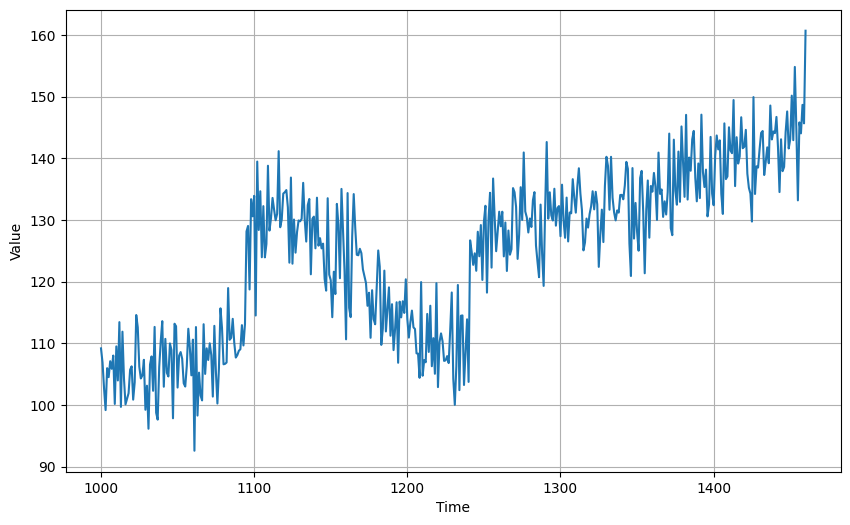

In [14]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [15]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [17]:
for feature, label in dataset.take(1):
  print(feature[:1])
  print(label[:1])

tf.Tensor(
[[ 76.99938   83.611145  72.53319   69.28865   66.25023   69.36341
   72.72827   81.7472    92.27583   96.02351   94.86356  100.92913
  107.66372   92.41701   92.66683  100.37789   98.60999  104.477905
   98.20821   93.53669 ]], shape=(1, 20), dtype=float32)
tf.Tensor([98.33139], shape=(1,), dtype=float32)


In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],
                           activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 2ms/step - loss: 191.6881
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 67.4751
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 59.5442
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 58.1524
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 56.7073
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 55.7377
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 54.0992
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 53.3554
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 52.5877
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 51.4789
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 51.5615
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 50.5051
Epoch 13/100
31/31 [====

In [20]:
print(series[1000:1020])
print(series[1020])
print(model.predict(series[1000:1020][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 92ms/step
[[103.15092]]
